## Using the updated IPCC AR5 reference regions in Python.

### Companion to the paper “An update of IPCC climate reference regions for subcontinental analysis of climate model data: Definition and aggregated datasets” (December 2019).

### Mathias Hauser - Institute for Atmospheric and Climate Science, ETH Zurich, Zurich, Switzerland

A new set of reference regions is defined updating the IPCC AR5 reference regions (http://www.ipcc-data.org/guidelines/pages/ar5_regions.html) for reporting sub-continental CMIP6 projections. This tutorial shows how the python package `regionmask` (https://github.com/mathause/regionmask, Hauser, 2019) can be used to plot these regions, and to create masks for climate data.

**NOTE:** The reference regions and context information are available at the ATLAS GitHub repository (https://github.com/SantanderMetGroup/ATLAS). 

## Requirements:

First, the package `xarray` (http://xarray.pydata.org/en/stable/, Hoyer and Hamman, 2017) will be used to load netCDF files. 

Import `xarray` and check the version:

In [27]:
import xarray as xr
xr.__version__

'0.14.1'

Currently the new updated regions are not included in a published version of `regionmask`, therefore it has to be directly installed from github.

pip install git+https://github.com/mathause/regionmask.git@feature/ar6_regions

The regions will be included in the next version (v0.6.0). 

Import `regionmask` and check the version:

In [28]:
import regionmask
regionmask.__version__

'0.4.0+dev'

Import additional packages:
 - `Matplotlib`: https://matplotlib.org/
 - `Cartopy`: https://pypi.org/project/Cartopy/
 - `Numpy`: https://numpy.org/

In [29]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

## Using the updated IPCC regions:

### Importing the reference regions:

The regions are available at `regionmask.defined_regions.ar6`. Four variants of the regions are provided (all, land, ocean, and separate_pacific):

In [30]:
regionmask.defined_regions.ar6


Regions defined for the sixt IPCC assessment report

Attributes
----------
all : Regions
    All regions (land + ocean), regions split along the date line
    are combined (see below).
land : Regions
    Land regions only, regions split along the date line
    are combined (see below).
ocean : Regions
    Ocean regions only, regions split along the date line
    are combined (see below).
separate_pacific : Regions
    Original definitions of the regions, no combination of the pacific
    regions.

Combined Regions
----------------
SPO and SPO*; EPO and EPO*; NPO and NPO*

Note
----
The region numbers for all, land, and ocean are consistent. The
region numbers for all and separate_pacific are not.


We will illustrate the use of `regionmask` considering all regions (land + ocean), corresponding to `regionmask.defined_regions.ar6.all`

In [31]:
ar6_all = regionmask.defined_regions.ar6.all

ar6_all

55 'IPCC AR6 WGI Reference Regions (combined Pacific regions)' Regions
GIC NEC CNA ENA NWN WNA NCA SCA CAR NWS SAM SSA SWS SES NSA NES NEU CEU EEU MED WAF SAH NEAF CEAF SWAF SEAF CAF RAR RFE ESB WSB WCA TIB EAS ARP SAS SEA NAU CAU SAU NZ EAN WAN ARO SPO EPO NPO SAO EAO NAO EIO SIO ARS BOB SOO

### Plotting regions:

`ar6_all.plot()` creates an cartopy map plot including the outline of all regions. It returns a axes instance.

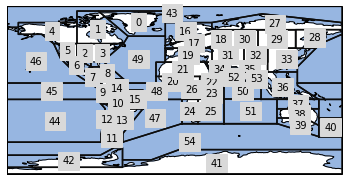

In [32]:
ax = ar6_all.plot()

The plot can also be customized:

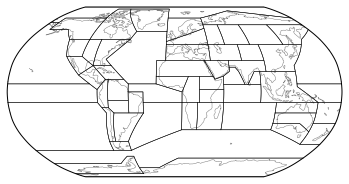

In [33]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson()))
ax = ar6_all.plot(
ax=ax,
add_ocean=False,
line_kws=dict(linewidth=0.5),
coastlines=False,
add_label=False,
);
ax.coastlines(color="0.5", lw=0.5);

### Selecting specific regions

Select a single region (note the double brackets):

In [34]:
ar6_all[[40]]

1 'IPCC AR6 WGI Reference Regions (combined Pacific regions)' Regions
NZ

and plot it

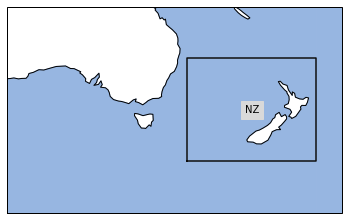

In [35]:
projection = ccrs.PlateCarree(central_longitude=180)

ax = ar6_all[[40]].plot(proj=projection, label="abbrev")

ax.set_extent([120, 185, -20, -60], ccrs.PlateCarree())

Regions can also be selected by their abbreviation, let’s select several regions at once:

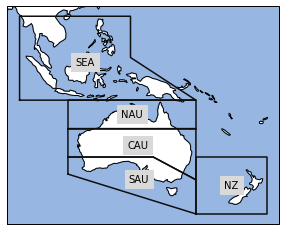

In [36]:
australasia = ar6_all[["NZ", "SEA", "NAU", "CAU", "SAU"]]

ax = australasia.plot(proj=projection, label="abbrev")

## Example with climate data:

In this example we will consider a NetCDF file with historical temperature simulations and show several analysis and visualizations at a global scale or filtering by regions. To this aim, we load using `xarray` an example dataset co to the following ESGF request: 
 - MIP Era: CMIP6
 - Source ID: CESM2
 - Experiment ID: historical
 - Variant Label: r1i1p1f1
 - Table ID: Amon
 - Frequency: mon
 - Variable: tas 

In [37]:
fN = ("./MyDir/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc")

ds = xr.open_dataset(fN)

# calculate annual mean
ds = ds.groupby("time.year").mean("time")

# extract tas and convert to celsius
tas = ds.tas - 273.15

/home/sixto/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


The example data is a temperature field. Let’s plot the first time step:

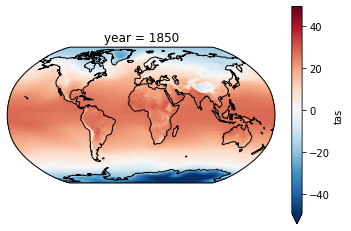

In [38]:
proj = ccrs.Robinson()

f, ax = plt.subplots(subplot_kw=dict(projection=proj))

tas.isel(year=0).plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), robust=True, center=0
)

ax.coastlines();

### Creating a region mask

Using `ar6_all.mask(lon, lat)` we can create an array where each grid cell is numbered according to the region it belongs to. Grid cells that are not part of any region are NaN. We can directly pass an `xarray` object containing lon and lat coordinates to the mask function. Let’s only use the land regions for this:

In [39]:
ar6_land = regionmask.defined_regions.ar6.land

In [40]:
mask = ar6_land.mask(tas)

Let’s plot the (region) mask:

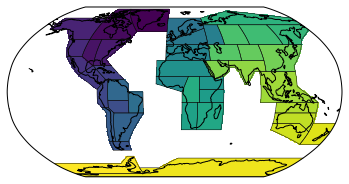

In [41]:
proj = ccrs.Robinson()
f, ax = plt.subplots(subplot_kw=dict(projection=proj))

h = mask.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False
)

ax.coastlines()

ar6_land.plot_regions(line_kws=dict(lw=0.5), add_label=False);

We want to select the region “Central North America” (CNA). Thus we first need to find out which number the region has:

In [42]:
CNA = ar6_land.map_keys("CNA")

CNA

2

### Selecting a specific region using `where`

`xarray` provides the where function which assigns NaN values to all grid points that are False:

In [43]:
tas_CNA = tas.where(mask == CNA)

Check everything went well by repeating the first plot with the selected region:

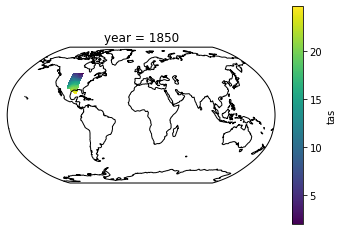

In [44]:
proj = ccrs.Robinson()

ax = plt.subplot(111, projection=proj)

tas_CNA.isel(year=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

Let’s take the area average and plot the time series. Each grid cell should be weighted by its correspoinding area. For the rectangular grid used here the cosine of the latitude is a good approximation. Unfortunately a weighted mean is not yet (as of version 0.14) implemented in `xarray`. Therefore, we have to define our own function (see `pydata/xarray/#2922` for details).

In [45]:
def weighted_mean(da, weights, dim):
    """Reduce da by a weighted mean along some dimension(s).
    
    Parameters
    ----------
    da : DataArray
        Object over which the weighted reduction operation is applied.
    weights : DataArray
        An array of weights associated with the values in this Dataset.
    dim : str or sequence of str, optional
        Dimension(s) over which to apply the weighted `mean`.

    Returns
    -------
    weighted_mean : DataArray
        New DataArray with weighted mean applied to its data and
        the indicated dimension(s) removed.
    """
    weighted_sum = (da * weights).sum(dim=dim, skipna=True)
    # need to mask weights where data is not valid
    masked_weights = weights.where(da.notnull())
    sum_of_weights = masked_weights.sum(dim=dim, skipna=True)
    valid_weights = sum_of_weights != 0
    sum_of_weights = sum_of_weights.where(valid_weights)
    
    return weighted_sum / sum_of_weights

Let’s compare the weighed with the unweighted mean it that actually makes a difference.

In [46]:
weights = np.cos(np.deg2rad(tas.lat))

ts_tas_CNA_unweighted = tas_CNA.mean(('lat', 'lon'))
ts_tas_CNA_weighted = weighted_mean(tas_CNA, weights, ('lat', 'lon'))

add the line plot

Text(0.5, 1.0, 'Central North America')

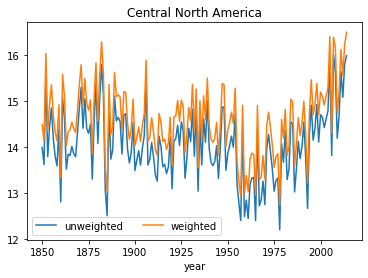

In [47]:
f, ax = plt.subplots()
ts_tas_CNA_unweighted.plot(ax=ax, label='unweighted')
ts_tas_CNA_weighted.plot(ax=ax, label='weighted')

plt.legend(ncol=2);
ax.set_title("Central North America")

Note how the weighted mean is larger than the unweighted..

### Using `regionmask` in production

It is not very practical to calculate each region mean by hand, therefore a function is provided that calculates the weighted average for all regions and additionaly adds the global mean, ocean mean, land mean, and a mean over all land except Antarctica,

In [48]:
def region_average(da, regions, land_only=True):
    """ Calculate regional average
    
        Parameters
        ----------
        da : DataArray
            Object over which the weighted reduction operation is applied.
        regions : regionmask.Regions
            regions to take the average over.
        land_only : bool, optional
            Whether to mask out ocean points before calculating regional means.
        
        Returns
        -------
        reg_ave : DataArray
            New DataArray with averaged over the whole globe, the ocean,
            the land, the land without Antarctica, and all regions.
            Dimensions (n_regions + 4) x (time)
    """
    
    if not isinstance(regions, regionmask.Regions):
        raise ValueError("'regions' must be a regionmask.Regions instance")
        
    abbrevs = ["global", "ocean", "land", "land_wo_antarctica"]
    abbrevs = abbrevs + regions.abbrevs
    
    numbers = np.array(regions.numbers)
    
    # get cosine weights
    weight = np.cos(np.deg2rad(da.lat))
    
    # get a land mask
    landmask = regionmask.defined_regions.natural_earth.land_110.mask(da)
    landmask = landmask == 0
    
    if land_only:
        wgt = weight * landmask
    else:
        # we need to add lon coordinates
        wgt = xr.full_like(landmask, 1) * weight
        
    mask = regions.mask(da)
    
    # list to accumulate averages
    ave = list()
    
    # global mean
    a = weighted_mean(da, dim=("lat", "lon"), weights=weight)
    ave.append(a)
    
    # global ocean mean
    weights = (weight * (1.0 - landmask))
    a = weighted_mean(da, dim=("lat", "lon"), weights=weights)
    ave.append(a)
    
    # global land mean
    weights = (weight * landmask)
    a = weighted_mean(da, dim=("lat", "lon"), weights=weights)
    ave.append(a)
    
    # global land mean w/o antarctica
    da_selected = da.sel(lat=slice(-60, None))
    weights = (weight * landmask)
    a = weighted_mean(da_selected, dim=("lat", "lon"), weights=weights)
    ave.append(a)
    
    # it is faster to calculate the weighted mean via groupby
    g = da.groupby(mask)
    wgt_stacked = wgt.stack(stacked_lat_lon=("lat", "lon"))
    a = g.apply(weighted_mean, dim=("stacked_lat_lon"), weights=wgt_stacked)
    ave.append(a.drop("region"))
    
    da = xr.concat(ave, dim="region")
    
    # shift region coordinates such that the numbers correspond to the
    # regions
    numbers = np.arange(numbers.min() - 4, numbers.max() + 1)
    
    # add the abbreviations of the regions, update the numbers
    da = da.assign_coords(
        **{"abbrev": ("region", abbrevs), "number": ("region", numbers)}
    )
    
    # create a multiindex
    da = da.set_index(region=("abbrev", "number"))
    
    return da

We set `land_only=False` so that the result is comparable to `ts_tas_CNA_weighted`.

The function can be used like so:

In [49]:
tas_reg_ave = region_average(tas, ar6_land, land_only=False)

It returns a `DataArray` of the form `n_regions` + 4 x time.

In [50]:
print(tas_reg_ave)

<xarray.DataArray (year: 165, region: 47)>
array([[ 14.05570509,  15.94685318,   9.40013865, ...,  13.73055188,
        -31.64397203, -19.63909115],
       [ 14.14698735,  15.94150805,   9.72929508, ...,  13.83234177,
        -30.65394993, -19.60219786],
       [ 13.98464357,  15.80148087,   9.51201302, ...,  14.23370685,
        -31.23482196, -20.11581554],
       ...,
       [ 15.23616381,  16.9465906 ,  11.02549118, ...,  14.43705979,
        -29.60729028, -16.8629853 ],
       [ 15.15337885,  16.88072324,  10.90105902, ...,  14.96161691,
        -30.37215337, -17.7697203 ],
       [ 14.9954769 ,  16.72866722,  10.72876572, ...,  15.34736543,
        -29.6835183 , -17.97165143]])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
  * region   (region) MultiIndex
  - abbrev   (region) object 'global' 'ocean' 'land' ... 'NZ' 'EAN' 'WAN'
  - number   (region) int64 -4 -3 -2 -1 0 1 2 3 4 ... 34 35 36 37 38 39 40 41 42


Regions can be selected by abbreviation (`tas_reg_ave.sel(abbrev="CNA")`) or number (`tas_reg_ave.sel(number=2)`). Compare the mean over CNA calculated with both methods:

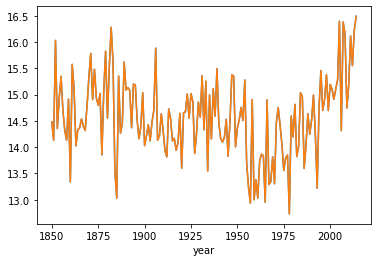

In [51]:
tas_reg_ave.sel(abbrev="CNA").plot()

ts_tas_CNA_weighted.plot.line()

The match - as a last thing we compare the global mean temperature with the land mean temperature:

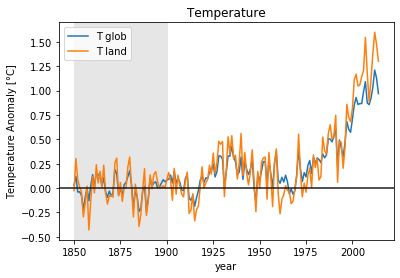

In [52]:
glob = tas_reg_ave.sel(abbrev="global")
land = tas_reg_ave.sel(abbrev="land")

# calculate anomalies wrt 1850 - 1900
glob -= glob.sel(year=slice(1850, 1900)).mean()
land -= land.sel(year=slice(1850, 1900)).mean()

# ==

f, ax = plt.subplots()

glob.plot(ax=ax, label="T glob")
land.plot(ax=ax, label="T land")

ax.legend(loc="upper left")

ax.axvspan(1850, 1900, color="0.9")
ax.axhline(0, color="0.1")

ax.set_ylabel("Temperature Anomaly [°C]")
ax.set_title("Temperature");

## References

Hauser M (2019), Regionmask: plotting and creation of masks of spatial regions in Python, Zenodo, doi:10.5281/zenodo.3585543.

Hoyer, S. and Hamman, J., 2017. xarray: N-D labeled Arrays and Datasets in Python. Journal of Open Research Software, 5(1), p.10. DOI: doi:10.5334/jors.148.
